In [1]:
import pandas as pd
import numpy as np
import json

from imblearn.over_sampling import SMOTE
from scipy.stats import skew, kurtosis
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_labels= 'data.info.txt'
df_labels = pd.read_csv(df_labels, delimiter=',')

df_raw = 'dataset0.json'

# Open the file and read line by line (each line = one read)
with open(df_raw, 'r') as file:
    data_list = []
    for line in file:
        try:
            data = json.loads(line)  # Parse each line as a separate JSON object
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(f"Error message: {e}")

In [3]:
# aggregating data_list
def create_aggregated_dataframe(data_list):
    rows = []
    for data in data_list:
        for transcript_id, positions in data.items():
            for position, sequence_data in positions.items():
                for sequence, measurements in sequence_data.items():
                    # Convert to numpy array for easier aggregation
                    scores_array = np.array(measurements)
                    
                    # Calculate the mean, sum, max, and min along the rows
                    mean_scores = np.mean(scores_array, axis=0)
                    var_scores = np.var(scores_array, axis=0)
                    max_scores = np.max(scores_array, axis=0)
                    min_scores = np.min(scores_array, axis=0)
                    # skew_scores = skew(scores_array, axis=0)
                    # kurtosis_scores = kurtosis(scores_array, axis=0)

                    transcript_position = {
                        'transcript_id': transcript_id,
                        'transcript_position': position,
                    }
                    
                    for idx in range(scores_array.shape[1]): 

                        transcript_position.update({
                            f'mean {idx}': mean_scores[idx],
                            f'var {idx}': var_scores[idx],
                            f'max {idx}': max_scores[idx],
                            f'min {idx}': min_scores[idx],
                            # f'skewness {idx}': skew_scores[idx],
                            # f'kurtosis {idx}': kurtosis_scores[idx]
                        })
                    rows.append(transcript_position)
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    return df

# Create the DataFrame
aggregated_df = create_aggregated_dataframe(data_list)

In [4]:
df_labels['transcript_position'] = df_labels['transcript_position'].astype(int)
aggregated_df['transcript_position'] = aggregated_df['transcript_position'].astype(int)

In [5]:
df_full = pd.merge(aggregated_df, df_labels[['gene_id','transcript_id', 'transcript_position', 'label']],
                   on=['transcript_id', 'transcript_position'], how='left')
print(df_full.columns)
df = df_full.drop([
    'transcript_id',
    'transcript_position',
], axis = 1)

Index(['transcript_id', 'transcript_position', 'mean 0', 'var 0', 'max 0',
       'min 0', 'mean 1', 'var 1', 'max 1', 'min 1', 'mean 2', 'var 2',
       'max 2', 'min 2', 'mean 3', 'var 3', 'max 3', 'min 3', 'mean 4',
       'var 4', 'max 4', 'min 4', 'mean 5', 'var 5', 'max 5', 'min 5',
       'mean 6', 'var 6', 'max 6', 'min 6', 'mean 7', 'var 7', 'max 7',
       'min 7', 'mean 8', 'var 8', 'max 8', 'min 8', 'gene_id', 'label'],
      dtype='object')


In [6]:
cluster_data = pd.read_pickle("clustered_dat_noscale.pkl")
pd.set_option('display.max_columns', None)
cluster_data['position'] = cluster_data['position'].astype(int)
merged_df = pd.merge(df_full, cluster_data, left_on=['transcript_id', 'transcript_position'], right_on=['transcript_id', 'position'], how='left')
df_full = merged_df.copy()
df = merged_df.drop(['transcript_id', 'transcript_position', 'position', 'rna_sequence'], axis=1)

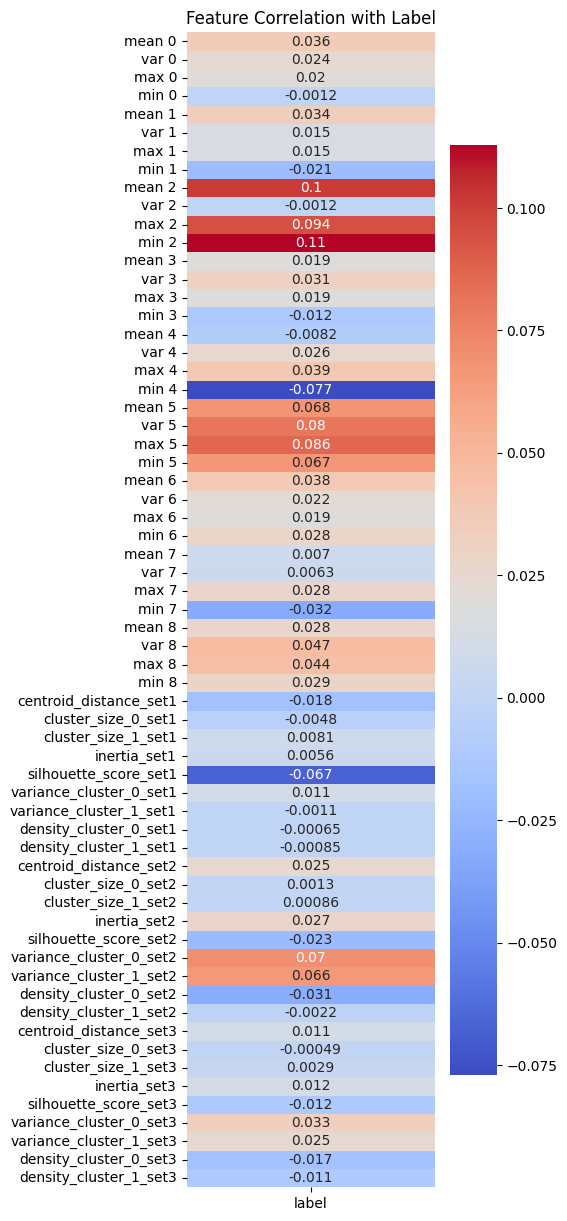

In [7]:
correlation_df = df.drop(['gene_id'], axis=1)
correlation_matrix = correlation_df.corr()
label_correlations = correlation_matrix['label'].drop('label')

plt.figure(figsize=(4, 15))
sns.heatmap(label_correlations.to_frame(), annot=True, cmap='coolwarm', cbar=True)
plt.title('Feature Correlation with Label')
plt.show()

In [8]:
print(df_full.columns)

Index(['transcript_id', 'transcript_position', 'mean 0', 'var 0', 'max 0',
       'min 0', 'mean 1', 'var 1', 'max 1', 'min 1', 'mean 2', 'var 2',
       'max 2', 'min 2', 'mean 3', 'var 3', 'max 3', 'min 3', 'mean 4',
       'var 4', 'max 4', 'min 4', 'mean 5', 'var 5', 'max 5', 'min 5',
       'mean 6', 'var 6', 'max 6', 'min 6', 'mean 7', 'var 7', 'max 7',
       'min 7', 'mean 8', 'var 8', 'max 8', 'min 8', 'gene_id', 'label',
       'position', 'rna_sequence', 'centroid_distance_set1',
       'cluster_size_0_set1', 'cluster_size_1_set1', 'inertia_set1',
       'silhouette_score_set1', 'variance_cluster_0_set1',
       'variance_cluster_1_set1', 'density_cluster_0_set1',
       'density_cluster_1_set1', 'centroid_distance_set2',
       'cluster_size_0_set2', 'cluster_size_1_set2', 'inertia_set2',
       'silhouette_score_set2', 'variance_cluster_0_set2',
       'variance_cluster_1_set2', 'density_cluster_0_set2',
       'density_cluster_1_set2', 'centroid_distance_set3',
       'cl

In [9]:
y = df_full[['label', 'transcript_id', 'transcript_position']]
x = df_full.drop(['label'], axis=1)

y = df_full[['label', 'transcript_id', 'transcript_position']]
x = df_full.drop(['label', 'position', 'rna_sequence'], axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
X_test = X_test.drop(['transcript_id', 'transcript_position', 'gene_id'], axis=1)
y_test = y_test['label']

In [11]:
X_train

,transcript_id,transcript_position,mean 0,var 0,max 0,min 0,mean 1,var 1,max 1,min 1,mean 2,var 2,max 2,min 2,mean 3,var 3,max 3,min 3,mean 4,var 4,max 4,min 4,mean 5,var 5,max 5,min 5,mean 6,var 6,max 6,min 6,mean 7,var 7,max 7,min 7,mean 8,var 8,max 8,min 8,gene_id,centroid_distance_set1,cluster_size_0_set1,cluster_size_1_set1,inertia_set1,silhouette_score_set1,variance_cluster_0_set1,variance_cluster_1_set1,density_cluster_0_set1,density_cluster_1_set1,centroid_distance_set2,cluster_size_0_set2,cluster_size_1_set2,inertia_set2,silhouette_score_set2,variance_cluster_0_set2,variance_cluster_1_set2,density_cluster_0_set2,density_cluster_1_set2,centroid_distance_set3,cluster_size_0_set3,cluster_size_1_set3,inertia_set3,silhouette_score_set3,variance_cluster_0_set3,variance_cluster_1_set3,density_cluster_0_set3,density_cluster_1_set3
24412,ENST00000268182,4336,0.010322,0.000010,0.0160,0.00457,3.205238,0.395444,5.16,2.240,108.952381,6.712018,112.0,100.0,0.010160,0.000028,0.0282,0.00378,6.728571,3.153850,10.90,3.70,118.809524,9.773243,124.0,113.0,0.009408,0.000015,0.0171,0.00316,3.187143,2.053906,6.97,1.720,86.628571,2.294422,89.7,84.0,ENSG00000140575,5.192065,4,17,61.965841,0.579217,2.721793,0.574595,1.469620,29.586071,5.402500,8,13,126.924384,0.422528,2.031627,2.004239,3.937731,6.486251,3.218001,9,12,38.058176,0.485632,0.953384,0.342134,9.440059,35.074014
55260,ENST00000345146,1996,0.007134,0.000018,0.0194,0.00232,1.813121,0.270745,3.49,0.882,104.079310,19.283710,111.0,94.8,0.008981,0.000024,0.0253,0.00199,2.563276,0.416070,5.12,1.27,106.522414,4.449325,110.0,99.3,0.005234,0.000007,0.0133,0.00166,2.754655,0.782473,6.45,1.500,92.277586,11.341394,105.0,83.4,ENSG00000138413,8.773322,40,18,178.655141,0.747098,0.947177,1.203591,42.230763,14.955245,5.135006,51,7,119.892943,0.641981,0.668942,0.835468,76.239803,8.378537,7.442276,7,51,362.265257,0.589080,4.350530,1.770615,1.608999,28.803549
78665,ENST00000379516,1862,0.006568,0.000009,0.0156,0.00266,3.917500,5.391235,12.40,2.260,109.791667,4.664931,116.0,107.0,0.006158,0.000019,0.0226,0.00232,7.191667,5.966297,11.60,3.30,118.708333,14.873264,126.0,111.0,0.007496,0.000011,0.0143,0.00232,3.353750,3.756248,10.50,1.690,80.775000,4.721875,86.4,77.8,ENSG00000205302,9.222902,2,22,85.401356,0.734626,1.774176,1.132671,1.127284,19.423111,6.586550,10,14,247.084543,0.438103,4.320138,2.797153,2.314741,5.005090,7.636370,22,2,96.565964,0.636193,1.290147,1.902709,17.052319,1.051133
70294,ENST00000371269,2592,0.010412,0.000037,0.0253,0.00199,4.143016,1.912923,11.30,2.300,115.730159,8.038297,121.0,108.0,0.007819,0.000022,0.0216,0.00222,6.370635,7.993368,14.70,1.63,114.603175,23.128244,129.0,103.0,0.008919,0.000016,0.0219,0.00232,2.866667,0.357149,4.17,1.190,81.815873,6.845780,92.7,75.8,ENSG00000116133,4.464370,28,35,316.897654,0.429833,1.552058,1.776427,18.040565,19.702474,7.724294,24,39,1074.215787,0.396609,6.497231,5.183035,3.693881,7.524548,3.829276,38,25,232.671447,0.471563,1.495034,0.829834,25.417475,30.126520
52117,ENST00000338369,813,0.006606,0.000017,0.0252,0.00232,3.261216,1.524305,8.46,1.820,120.864865,15.306063,128.0,110.0,0.007618,0.000022,0.0272,0.00232,6.015946,5.229502,13.50,2.20,126.378378,8.748722,132.0,114.0,0.006335,0.000015,0.0221,0.00232,4.197162,3.465874,10.30,1.240,79.882432,16.725232,89.7,71.7,ENSG00000172500,9.845072,65,9,479.213543,0.674163,2.284614,1.248662,28.451200,7.207714,4.595760,27,47,672.193375,0.345342,2.084304,3.569963,12.953962,13.165404,7.702591,22,52,576.934583,0.550041,3.499829,2.217602,6.286021,23.448757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,ENST00000552551,1370,0.007304,0.000027,0.0362,0.00166,8.752857,6.822261,16.10,1.680,119.823954,38.168142,135.0,101.0,0.008027,0.000020,0.0339,0.00199,3.603102,1.103836,9.47,1.49,97.095815,5.1239

In [12]:
df_train = pd.merge(X_train, y_train[['transcript_id', 'transcript_position', 'label']],
                   on=['transcript_id', 'transcript_position'], how='left')

In [13]:
def sample_with_ratio(group):
    # Separate the group into label 1 and label 0
    label_1 = group[group['label'] == 1]
    label_0 = group[group['label'] == 0]
    
    # For label_1 data
    if len(label_0) == 0:
        # No label_0 data in group
        # Limit label_1 data to at most 5
        sample_label_1 = label_1.sample(n=min(len(label_1), 5), random_state=42)
        sample_label_0 = pd.DataFrame()  # No label_0 data
    else:
        # Calculate the maximum allowed label_1 instances (5:1 ratio)
        max_label_1 = 5 * len(label_0)
        
        if len(label_1) <= max_label_1:
            # Take all label_1 data
            sample_label_1 = label_1
        else:
            # Sample label_1 data to have len(label_1) = 5 * len(label_0)
            sample_label_1 = label_1.sample(n=max_label_1, random_state=42)
        
        # Limit label_0 data to at most 2 rows per group
        sample_label_0 = label_0.sample(n=min(len(label_0), 2), random_state=42)
    
    # Combine the two samples
    combined_sample = pd.concat([sample_label_1, sample_label_0])
    
    # Limit the total rows to 10 if necessary
    if len(combined_sample) > 10:
        combined_sample = combined_sample.sample(n=10, random_state=42)
    
    # Get the remaining data not included in the sample
    sampled_indices = combined_sample.index
    remaining_data = group.drop(sampled_indices)
    
    return combined_sample, remaining_data

sampled_list = []
remaining_list = []

# Group the DataFrame and apply the function
for name, group in df_train.groupby('gene_id'):
    sampled, remaining = sample_with_ratio(group)
    sampled_list.append(sampled)
    remaining_list.append(remaining)

# Combine the lists into DataFrames
df_full = pd.concat(sampled_list).reset_index(drop=True)
df_blind_test = pd.concat(remaining_list).reset_index(drop=True)

In [14]:
df_full = df_full.drop(['gene_id'], axis=1)
df_blind_test = df_blind_test.drop(['gene_id'], axis=1) # Extra from what was removed from the undersampling of 0s (A lot of 0s with some 1s)

x = df_full.drop(columns=['label'], axis=1)
x = x.drop(['transcript_id', 'transcript_position'], axis=1)
y_train = df_full['label']

x_blind = df_blind_test.drop(columns=['label'], axis=1)
x_blind = x_blind.drop(['transcript_id', 'transcript_position'], axis=1)
y_blind = df_blind_test['label']

In [15]:
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x, y_train)

# Comment this out to not use SMOTE
x, y_train = x_smote, y_smote

In [16]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x)
X_test_scaled = scaler.transform(X_test)

In [35]:
# pd.DataFrame(X_test_scaled)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
0,-0.661076,-0.851929,-1.341347,0.358000,-1.155226,-0.285870,-1.364610,-1.024434,-0.900483,-0.808381,-1.195395,-0.244201,-0.979551,-0.675077,-0.539054,0.503644,-1.382383,-0.699821,-1.272621,-0.775940,-1.304704,-0.952058,-1.263627,-1.070190,-1.409159,-0.892834,-0.714938,-0.162110,-0.698799,-0.250298,-0.651481,0.103038,0.622528,0.052924,0.696575,0.710597,-0.729525,-0.377711,-0.402620,-0.478388,1.487327,-1.185208,-1.100247,0.565668,0.270593,-0.807158,-0.332109,-0.476223,-0.465995,-0.534179,-0.776363,-1.054021,-0.191644,-0.254939,-0.215831,-0.391814,-0.401890,-0.407951,-0.187697,-0.235726,-0.325819,-0.392171,-0.349131
1,-0.402192,-0.512038,-0.577019,-0.025213,-0.408263,-0.058990,-0.096452,-0.404237,-0.656834,-0.588576,-0.823591,-0.348229,-1.779306,-1.389996,-1.808637,-0.156327,1.885195,1.038905,0.715146,3.013629,0.070784,0.889503,0.032286,0.173772,0.582891,-0.161957,-0.429919,-0.162110,-0.464935,-0.264104,-0.632562,0.649813,-1.329112,0.293846,-0.417719,-1.092917,-0.629450,-0.442819,-0.328312,-0.394967,-1.037357,-0.908253,-0.157570,-0.232740,-0.337497,0.568148,-0.435718,-0.351129,-0.310282,0.245201,0.061274,0.709564,-0.391986,-0.376074,0.213822,-0.553047,-0.222880,-0.384900,1.010343,2.693631,-0.622558,-0.561313,-0.071548
2,0.423031,0.191516,-0.116328,-1.430327,2.034012,-0.154875,0.463896,4.785647,-0.466194,1.047863,-0.265884,-1.773418,2.003616,-0.056448,0.102808,0.581288,0.167389,-0.256438,-0.238810,-0.588337,1.341639,-1.170334,1.069016,1.775846,-1.060759,-0.977339,-1.136271,0.695895,1.136800,0.188758,0.147872,1.369254,-1.443026,-0.233198,-1.775132,-1.151095,0.136134,-0.299582,-0.135110,0.088539,-0.677063,2.644306,0.107999,-0.455606,-0.268601,-0.833610,-0.202598,-0.257308,-0.391378,-0.692942,-0.984360,-0.599990,0.099727,-0.174490,-0.152325,-0.176836,-0.282550,-0.209272,-0.219904,-0.348877,0.475073,-0.180787,-0.361054
3,0.322110,-0.495087,-0.493257,1.401190,1.378807,0.380121,0.849561,1.972989,1.498673,-0.050722,1.314285,1.316225,0.187578,-0.829693,-0.974216,0.988917,0.003293,-0.269202,-0.260392,1.362728,-1.528886,0.196147,-1.177233,-1.390605,-0.933233,-0.951091,-1.161055,-1.827650,0.076391,-0.169708,-0.393702,1.167810,0.518270,-0.430651,0.372417,0.710597,0.948767,-0.260517,-0.506652,-0.285519,1.026537,0.283070,0.562787,-0.357473,-0.459492,-0.061793,-0.474571,-0.272945,-0.365649,-0.266962,0.919453,-0.598476,-0.434049,-0.188326,-0.390115,-0.472430,-0.282550,-0.411487,-0.737831,-0.208761,-0.447620,-0.460082,-0.219212
4,0.635069,0.677024,0.595649,-0.727770,-0.254234,0.000646,-0.137287,-1.091515,0.378092,-0.268668,0.291823,0.483998,0.912257,3.045695,4.117170,-0.796887,1.087165,0.846524,0.974138,-0.375721,0.413119,1.456237,0.550651,0.362252,0.518281,0.033351,-0.095331,-0.162110,0.248671,-0.137915,-0.076798,1.081477,-0.799444,0.087906,-0.741877,-0.918383,-0.399177,-0.234474,0.176985,-0.052955,-1.263666,0.161822,-0.135474,-0.332736,-0.032457,0.479161,-0.163744,0.102338,0.371206,-0.531543,2.292345,0.448133,-0.383976,-0.191412,-0.172437,-0.015603,-0.073705,-0.103644,-0.205502,-0.238826,-0.113058,-0.086234,-0.165004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48731,-0.930262,-0.439670,0.951638,-0.727770,2.374189,0.280756,1.598205,1.325724,0.471932,0.729527,1.128383,-0.514675,0.835735,0.563146,2.061034,-0.796887,-0.831603,-0.587236,0.024499,-0.138092,-1.721488,-1.029394,-1.522810,-1.569660,2.453721,3.004378,2.990310,-0.162110,-1.217617,-0.353749,-0.793379,-0.242293,0.014670,-1.108090,-0.478499,-0.355997,0.104665,1.223941,1.053825,2.493025,-1.191144,1.466822,1.295381,-0.046797,-0.051562,-0.910728,1.377440,0.915452,0.131920,-0.342028,-1.168934,-0.451908,3.760643

#### Random Forest

In [17]:
### RANDOM FOREST
print("Random Forest")
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print("Test Data Set")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

Random Forest
Test Data Set
Accuracy: 0.8820379185817465
ROC AUC: 0.8852416271621926
PR AUC: 0.3363327053923578
              precision    recall  f1-score   support

           0       0.98      0.89      0.94     46561
           1       0.23      0.70      0.35      2175

    accuracy                           0.88     48736
   macro avg       0.61      0.79      0.64     48736
weighted avg       0.95      0.88      0.91     48736



In [18]:
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(random_state=42)

#Takes about 4 minutes for me (yucai) to run this

# Parameters grid
param_grid = {
    'n_estimators': [500, 700, 900], # Default = 100
    'max_depth': [None, 5, 10], # Default = None
    'min_samples_split': [1, 2, 3], # Default = 2
    'min_samples_leaf': [1, 2, 4] # Default = 1
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Users\andre\OneDrive\Desktop\y4s1\grp_proj\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
81 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\andre\OneDrive\Desktop\y4s1\grp_proj\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\andre\OneDrive\Desktop\y4s1\grp_proj\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\andre\OneDrive\Desktop\y4s1\grp_proj\lib\site-packages\sklearn\base.py", line 666, in _validate_params
  

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 900}


In [19]:
# Best model
best_rf = grid_search.best_estimator_

# Predictions
y_pred = best_rf.predict(X_test_scaled)
y_pred_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print("Test Data Set")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

Test Data Set
Accuracy: 0.8833716349310571
ROC AUC: 0.8888860910924661
PR AUC: 0.34481204334773224
              precision    recall  f1-score   support

           0       0.98      0.89      0.94     46561
           1       0.23      0.71      0.35      2175

    accuracy                           0.88     48736
   macro avg       0.61      0.80      0.64     48736
weighted avg       0.95      0.88      0.91     48736



#### XGBoost

In [20]:
### XBOOST
print("XGBoost")
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# try picking top10 features only
X_train_scaled1 = pd.DataFrame(X_train_scaled).iloc[:, [8, 21, 20, 16, 19, 32, 3, 10, 33, 23]]
X_train_scaled1 = (X_train_scaled1).to_numpy()
X_test_scaled1 = pd.DataFrame(X_test_scaled).iloc[:, [8, 21, 20, 16, 19, 32, 3, 10, 33, 23]]
X_test_scaled1 = (X_test_scaled1).to_numpy()

model.fit(X_train_scaled1, y_train)
y_pred = model.predict(X_test_scaled1)

y_pred = model.predict(X_test_scaled1)
y_pred_proba = model.predict_proba(X_test_scaled1)[:, 1]

# importances = model.feature_importances_
# feature_importance_df = pd.DataFrame({
#     'Feature': pd.DataFrame(X_train_scaled).columns,
#     'Importance': importances
# }).sort_values(by='Importance', ascending=False)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

# feature_importance_df.head(10)

XGBoost
Accuracy: 0.8747332567301379
ROC AUC: 0.8858992738977689
PR AUC: 0.3608970810433451
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     46561
           1       0.22      0.71      0.34      2175

    accuracy                           0.87     48736
   macro avg       0.60      0.80      0.63     48736
weighted avg       0.95      0.87      0.90     48736



c:\Users\andre\OneDrive\Desktop\y4s1\grp_proj\lib\site-packages\xgboost\core.py:158: UserWarning: [03:11:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [21]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Takes ~2 minutes to run

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500, 800], # Default = 100
    'max_depth': [3, 6, 9, 12], # Default = 6
    'learning_rate': [0.01, 0.1, 0.2], 
    'subsample': [0.6, 0.8, 1.0], # Default = 1
    'colsample_bytree': [0.6, 0.8, 1.0], # Default = 1
    'gamma': [0, 0.1, 0.2] # Default = 0
}

xgb_clf = xgb.XGBClassifier(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)


Best parameters found:  {'subsample': 0.8, 'n_estimators': 800, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}


In [22]:
best_params = random_search.best_params_

print("XGBoost")
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

XGBoost


c:\Users\andre\OneDrive\Desktop\y4s1\grp_proj\lib\site-packages\xgboost\core.py:158: UserWarning: [03:15:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9028438936309915
ROC AUC: 0.9013646663491991
PR AUC: 0.3835478339573559
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     46561
           1       0.27      0.71      0.39      2175

    accuracy                           0.90     48736
   macro avg       0.63      0.81      0.67     48736
weighted avg       0.95      0.90      0.92     48736



dataset1

In [23]:
df_raw = 'dataset1.json'

# Open the file and read line by line (each line = one read)
with open(df_raw, 'r') as file:
    data_list = []
    for line in file:
        try:
            data = json.loads(line)  # Parse each line as a separate JSON object
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(f"Error message: {e}")

aggregated_df = create_aggregated_dataframe(data_list)
aggregated_df['transcript_position'] = aggregated_df['transcript_position'].astype(int)

In [24]:
cluster_data = pd.read_pickle("clustered_dat_noscale1.pkl")
pd.set_option('display.max_columns', None)
cluster_data['position'] = cluster_data['position'].astype(int)
merged_df = pd.merge(aggregated_df, cluster_data, left_on=['transcript_id', 'transcript_position'], right_on=['transcript_id', 'position'], how='left')
df_full = merged_df.copy()
df = merged_df.drop(['transcript_id', 'transcript_position', 'position', 'rna_sequence'], axis=1)

In [39]:
print(df_full.columns)

Index(['transcript_id', 'transcript_position', 'mean 0', 'var 0', 'max 0',
       'min 0', 'mean 1', 'var 1', 'max 1', 'min 1', 'mean 2', 'var 2',
       'max 2', 'min 2', 'mean 3', 'var 3', 'max 3', 'min 3', 'mean 4',
       'var 4', 'max 4', 'min 4', 'mean 5', 'var 5', 'max 5', 'min 5',
       'mean 6', 'var 6', 'max 6', 'min 6', 'mean 7', 'var 7', 'max 7',
       'min 7', 'mean 8', 'var 8', 'max 8', 'min 8', 'position',
       'rna_sequence', 'centroid_distance_set1', 'cluster_size_0_set1',
       'cluster_size_1_set1', 'inertia_set1', 'silhouette_score_set1',
       'variance_cluster_0_set1', 'variance_cluster_1_set1',
       'density_cluster_0_set1', 'density_cluster_1_set1',
       'centroid_distance_set2', 'cluster_size_0_set2', 'cluster_size_1_set2',
       'inertia_set2', 'silhouette_score_set2', 'variance_cluster_0_set2',
       'variance_cluster_1_set2', 'density_cluster_0_set2',
       'density_cluster_1_set2', 'centroid_distance_set3',
       'cluster_size_0_set3', 'cluste

In [50]:
d = df_full.drop(['transcript_id', 'transcript_position', 'position',
       'rna_sequence'], axis=1)
X_test_scaled_1 = scaler.transform(d)
# X_test_scaled_1
y_pred_proba_test1 = model.predict_proba(X_test_scaled_1)

display(pd.DataFrame(y_pred_proba_test1[:,1]))

,0
0,0.000470
1,0.015433
2,0.000060
3,0.001988
4,0.002055
...,...
90805,0.012537
90806,0.000011
90807,0.674398
90808,0.000171
